In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from sklearn.metrics import r2_score
from scipy.special import rel_entr

from biological_fuzzy_logic_networks.manuscripts_functions.colors import models_dict
from biological_fuzzy_logic_networks.manuscripts_functions.metrics import compute_scalar_mmd, wasserstein_distance

In [2]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": 8,"axes.titlesize":8,"axes.labelsize":8, 
                                               "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 8


In [10]:
test_input = False
train_input = True
test_y = False
train_y = True

base_dir = "/dccstor/ipc1/CAR/BFN/Model/Noise/"
noise_range = 4
n_runs = 5

markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

output_markers = list(set(markers).difference(set(["igf1", "tgfa", "tnfa", "il1a"])))


In [45]:
def compute_MMD(data, markers=output_markers):
    data["cell_id"] = len(data['marker'].unique())*[i for i in range(int(len(data)/len(data["marker"].unique())))] 
    
    pred = data[["cell_id", "marker", "pred"]]
    pred = pred.set_index("cell_id").pivot(columns="marker")
    
    
    true = data[["cell_id", "marker", "true"]]
    true = true.set_index("cell_id").pivot(columns="marker")
    mmd = compute_scalar_mmd(true, pred)
    
    return mmd


def compute_wasserstein(data, markers=output_markers):
    data["cell_id"] = len(data['marker'].unique())*[i for i in range(int(len(data)/len(data["marker"].unique())))] 
    
    pred = data[["cell_id", "marker", "pred"]]
    pred = pred.set_index("cell_id").pivot(columns="marker")
    
    
    true = data[["cell_id", "marker", "true"]]
    true = true.set_index("cell_id").pivot(columns="marker")
    emd = wasserstein_distance(true, pred)
    
    return emd

def compute_R2(data):
    out = r2_score(data["true"], data['pred'])
    return out

# Baseline without noise

In [12]:
no_noise_outputs = []
no_noise_trues = []
for i in range(n_runs):
    
    run_output = pd.read_csv(os.path.join(base_dir, "Error_sd_0", f"{i+1}_unperturbed.csv"), index_col=1)
    run_output = run_output.rename(columns={"Unnamed: 0": "model"})
    run_output["noise_sd"] = 0
    run_output["repeat"] = i+1
    
    no_noise_outputs.append(run_output[run_output["model"]!="teacher_true"])
    no_noise_trues.append(run_output[run_output["model"]=="teacher_true"])

no_noise_output = pd.concat(no_noise_outputs).reset_index(drop=False)
no_noise_true = pd.concat(no_noise_trues).reset_index(drop=False).drop("model", axis=1)

no_noise_pred_long = no_noise_output.melt(id_vars=["index", "noise_sd", "repeat", "model"], var_name="marker", value_name="pred")
no_noise_true_long = no_noise_true.melt(id_vars=["index", "noise_sd", "repeat"], var_name="marker", value_name="true")

no_noise_df = no_noise_pred_long.merge(no_noise_true_long, on=["index", "repeat", "marker", "noise_sd"]).dropna()
no_noise_df = no_noise_df.drop("index", axis=1)
no_noise_df["error"] = (no_noise_df["true"] - no_noise_df["pred"])
no_noise_df["sq_err"] = no_noise_df["error"]**2
no_noise_df["abs_error"] = abs(no_noise_df["error"])
no_noise_df = no_noise_df[no_noise_df["model"]!="teacher_true"]
no_noise_df[(no_noise_df['marker']=="mek12")&(no_noise_df["model"]=="student_same_input")]

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,0,1,student_same_input,mek12,0.554010,0.554040,3.056617e-05,9.342907e-10,3.056617e-05
4,0,1,student_same_input,mek12,0.409068,0.409097,2.920545e-05,8.529583e-10,2.920545e-05
8,0,1,student_same_input,mek12,0.027671,0.027665,-6.618128e-06,4.379962e-11,6.618128e-06
12,0,1,student_same_input,mek12,0.115756,0.115753,-2.772181e-06,7.684986e-12,2.772181e-06
16,0,1,student_same_input,mek12,0.042368,0.042361,-7.410069e-06,5.490912e-11,7.410069e-06
...,...,...,...,...,...,...,...,...,...
39980,0,5,student_same_input,mek12,0.456712,0.456767,5.485486e-05,3.009056e-09,5.485486e-05
39984,0,5,student_same_input,mek12,0.999999,0.999999,-6.043828e-09,3.652786e-17,6.043828e-09
39988,0,5,student_same_input,mek12,0.962665,0.962675,1.043806e-05,1.089530e-10,1.043806e-05
39992,0,5,student_same_input,mek12,0.216239,0.216266,2.685442e-05,7.211598e-10,2.685442e-05


In [13]:
no_noise_df

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,0,1,student_same_input,mek12,0.554010,0.554040,3.056617e-05,9.342907e-10,3.056617e-05
1,0,1,student_random_input,mek12,0.001435,0.554040,5.526054e-01,3.053727e-01,5.526054e-01
2,0,1,untrained_same_input,mek12,0.725604,0.554040,-1.715637e-01,2.943410e-02,1.715637e-01
3,0,1,untrained_random_input,mek12,0.911820,0.554040,-3.577799e-01,1.280065e-01,3.577799e-01
4,0,1,student_same_input,mek12,0.409068,0.409097,2.920545e-05,8.529583e-10,2.920545e-05
...,...,...,...,...,...,...,...,...,...
519995,0,5,untrained_random_input,hsp27,0.000013,0.010591,1.057794e-02,1.118929e-04,1.057794e-02
519996,0,5,student_same_input,hsp27,1.000000,1.000000,-2.642331e-14,6.981912e-28,2.642331e-14
519997,0,5,student_random_input,hsp27,0.675177,1.000000,3.248233e-01,1.055102e-01,3.248233e-01
519998,0,5,untrained_same_input,hsp27,1.000000,1.000000,-3.510525e-13,1.232379e-25,3.510525e-13


In [15]:
no_noise_grouped = no_noise_df.groupby(["noise_sd", "repeat", "model", "marker"]).mean()
no_noise_grouped["R2"] = no_noise_df.groupby(["noise_sd", "repeat", "model", "marker"]).apply(compute_R2)
no_noise_grouped = no_noise_grouped.reset_index(drop=False)
no_noise_grouped = no_noise_grouped.rename(columns={"sq_err": "MSE"})
no_noise_grouped

,noise_sd,repeat,model,marker,pred,true,error,MSE,abs_error,R2
0,0,1,student_random_input,akt,0.901060,0.921490,0.020430,0.082274,0.150350,-1.278469
1,0,1,student_random_input,erk12,0.334933,0.344646,0.009713,0.400740,0.454136,-1.063596
2,0,1,student_random_input,hsp27,0.428295,0.435443,0.007148,0.466037,0.491600,-1.007488
3,0,1,student_random_input,ikb,0.868507,0.888875,0.020368,0.159846,0.210630,-1.199526
4,0,1,student_random_input,ikk,0.854734,0.875860,0.021125,0.135986,0.220294,-1.200608
...,...,...,...,...,...,...,...,...,...,...
255,0,5,untrained_same_input,mek12,0.341737,0.506385,0.164648,0.066220,0.166138,0.576760
256,0,5,untrained_same_input,mkk4,0.506220,0.482360,-0.023860,0.002259,0.026417,0.988057
257,0,5,untrained_same_input,p38,0.460129,0.453708,-0.006421,0.001656,0.020674,0.991857
258,0,5,untrained_same_input,pi3k,0.861514,0.878968,0.017454,0.000945,0.018010,0.979095


In [47]:
no_noise_mmd = no_noise_df.groupby(["noise_sd", "repeat", "model"]).mean(numeric_only=True)
no_noise_mmd["MMD"] = no_noise_df.groupby(["noise_sd", "repeat", "model"]).apply(compute_MMD)
no_noise_mmd["EMD"] = no_noise_df.groupby(["noise_sd", "repeat", "model"]).apply(compute_wasserstein)


In [48]:
no_noise_mmd

pred      true     error  \
noise_sd repeat model                                                  
0        1      student_random_input    0.595781  0.610082  0.014301   
                student_same_input      0.610226  0.610082 -0.000144   
                untrained_random_input  0.567822  0.610082  0.042260   
                untrained_same_input    0.583960  0.610082  0.026122   
         2      student_random_input    0.633339  0.632807 -0.000532   
                student_same_input      0.632878  0.632807 -0.000072   
                untrained_random_input  0.608681  0.632807  0.024126   
                untrained_same_input    0.606158  0.632807  0.026649   
         3      student_random_input    0.578607  0.569550 -0.009057   
                student_same_input      0.569679  0.569550 -0.000129   
                untrained_random_input  0.676699  0.569550 -0.107149   
                untrained_same_input    0.669192  0.569550 -0.099642   
         4      student_random_input    0.583811  0.575067 -0.008744   
                student_same_input      0.575123  0.575067 -0.000057   
                untrained_random_input  0.605485  0.575067 -0.030418   
                untrained_same_input    0.607982  0.575067 -0.032916   
         5      student_random_input    0.600947  0.595217 -0.005731   
                student_same_input      0.595285  0.595217 -0.000069   
                untrained_random_input  0.585186  0.595217  0.010030   
                untrained_same_input    0.585683  0.595217  0.009534   

                                              sq_err  abs_error           MMD  \
noise_sd repeat model                                                           
0        1      student_random_input    2.716412e-01   0.356395  5.660504e-04   
                student_same_input      3.713725e-06   0.000546  5.463759e-07   
                untrained_random_input  2.816569e-01   0.371200  1.022153e-02   
                untrained_same_input    1.930283e-02   0.059855  7.375131e-03   
         2      student_random_input    2.954450e-01   0.388525  3.141984e-04   
                student_same_input      4.101249e-07   0.000189  2.607703e-07   
                untrained_random_input  2.966501e-01   0.390953  1.592039e-02   
                untrained_same_input    3.984881e-02   0.096400  1.855167e-02   
         3      student_random_input    2.846954e-01   0.382011  4.328713e-04   
                student_same_input      1.610612e-06   0.000503  5.016724e-07   
                untrained_random_input  2.974384e-01   0.392247  2.420538e-02   
                untrained_same_input    5.144862e-02   0.109280  2.188812e-02   
         4      student_random_input    2.951802e-01   0.388119  3.631761e-04   
                student_same_input      3.638428e-07   0.000188  1.092752e-07   
                untrained_random_input  3.058678e-01   0.402022  8.564276e-03   
                untrained_same_input    1.505788e-02   0.059441  9.806514e-03   
         5      student_random_input    3.020001e-01   0.400682  2.168765e-04   
                student_same_input      7.275126e-07   0.000252 -6.953875e-08   
                untrained_random_input  2.938206e-01   0.390656  7.208544e-03   
                untrained_same_input    1.393397e-02   0.052694  9.461085e-03   

                                               EMD  
noise_sd repeat model                               
0        1      student_random_input      0.534577  
                student_same_input        0.496553  
                untrained_random_input   0.7281744  
                untrained_same_input     0.6701735  
         2      student_random_input     0.5387184  
                student_same_input       0.5112876  
                untrained_random_input   0.7951886  
                untrained_same_input     0.8251763  
         3      student_random_input    0.58253515  
                student_same_input      0.54613817  
                untrained_random_input  

# Load experiments

In [49]:
experiment_name = []

if train_input:
    experiment_name.append("tri")
if train_y:
    experiment_name.append("try")
if test_input:
    experiment_name.append("tei")
if test_y:
    experiment_name.append("tey")
    
experiment_name = "_".join(experiment_name)
print(experiment_name)

tri_try


In [50]:
experiment_names= ["tei", "tri", "tri_tei", "tri_try_tei"]

In [51]:
outputs = []
trues = []
for i in range(n_runs):
    for n in range(noise_range):
        run_output = pd.read_csv(os.path.join(base_dir, f"Error_sd_{n+1}", experiment_name, f"{i+1}_unperturbed.csv"), index_col=1)
        run_output = run_output.rename(columns={"Unnamed: 0": "model"})
        run_output["noise_sd"] = n+1
        run_output["repeat"] = i+1
        
        outputs.append(run_output[run_output["model"]!="teacher_true"])
        trues.append(run_output[run_output["model"]=="teacher_true"])

In [52]:
run_output

,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,igf1,il1a,tgfa,tnfa,noise_sd,repeat
0,teacher_true,0.567533,0.521562,0.448538,0.500041,0.562891,0.438063,0.476329,0.487921,0.495904,0.465319,0.522716,0.527450,0.482303,0.502232,0.440760,0.500256,0.510473,4,5
1,teacher_true,0.578721,0.543867,0.448335,0.499986,0.556589,0.432966,0.485156,0.477025,0.495003,0.464288,0.522708,0.527416,0.482300,0.486406,0.438476,0.505757,0.497108,4,5
2,teacher_true,0.577071,0.543493,0.448445,0.500009,0.558865,0.434477,0.483143,0.478506,0.493163,0.467514,0.522515,0.527420,0.482302,0.472537,0.444395,0.504368,0.495717,4,5
3,teacher_true,0.579836,0.543889,0.481627,0.534078,0.587764,0.467092,0.487833,0.511165,0.495889,0.493376,0.522716,0.562633,0.513930,0.491128,0.467039,0.508043,0.507271,4,5
4,teacher_true,0.549189,0.511530,0.448934,0.500137,0.561586,0.436754,0.458875,0.486214,0.481264,0.468370,0.506423,0.527499,0.482301,0.483932,0.447426,0.485704,0.506182,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,untrained_random_input,0.687210,0.503421,1.000000,1.000000,1.000000,1.000000,0.553989,0.999768,0.999977,0.997445,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,4,5
1996,untrained_random_input,0.975727,0.997920,0.293264,0.241033,1.000000,1.000000,0.765104,0.999691,1.000000,0.335443,1.000000,0.145876,0.076788,NaN,NaN,NaN,NaN,4,5
1997,untrained_random_input,0.992403,0.999869,0.028514,0.014159,0.999995,1.000000,0.819253,0.988210,1.000000,0.053352,1.000000,0.006520,0.002597,NaN,NaN,NaN,NaN,4,5
1998,untrained_random_input,1.000000,1.000000,0.502518,0.381148,0.848414,0.989709,0.999378,0.565392,1.000000,0.620541,1.000000,0.262798,0.138388,NaN,NaN,NaN,NaN,4,5


In [53]:
true = pd.concat(trues).reset_index(drop=False).drop("model", axis=1)
output = pd.concat(outputs).reset_index(drop=False)
# output.loc[output["hsp27"]<-10, "hsp27"] = -10 # For outliers in tri_try_tei
true

,index,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,igf1,il1a,tgfa,tnfa,noise_sd,repeat
0,0,0.504538,0.571862,0.542710,0.470249,0.490627,0.492620,0.517047,0.537129,0.536827,0.472809,0.514317,0.387169,0.427484,0.534037,0.471034,0.543385,0.557889,1,1
1,1,0.486932,0.543573,0.537235,0.463918,0.490622,0.492620,0.511934,0.537118,0.536782,0.457277,0.514317,0.384025,0.426261,0.487395,0.459459,0.540312,0.558853,1,1
2,2,0.440599,0.493938,0.648164,0.575525,0.490636,0.492620,0.472787,0.538610,0.536837,0.549602,0.514317,0.498026,0.550268,0.592573,0.526624,0.513178,0.541781,1,1
3,3,0.451299,0.501762,0.625107,0.573571,0.490632,0.492620,0.493821,0.522129,0.535033,0.534060,0.514296,0.489535,0.548815,0.570378,0.509483,0.528948,0.495917,1,1
4,4,0.442384,0.495120,0.534775,0.460090,0.443224,0.460093,0.479171,0.476523,0.515274,0.462454,0.506109,0.382098,0.425847,0.509937,0.464045,0.518426,0.491125,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1995,0.562709,0.515172,0.471378,0.528955,0.586415,0.467076,0.473199,0.500042,0.495501,0.485817,0.522716,0.548596,0.496360,0.499862,0.457773,0.498377,0.506907,4,5
39996,1996,0.580052,0.543889,0.448346,0.499989,0.556934,0.433175,0.490415,0.476994,0.495937,0.465000,0.522716,0.527416,0.482300,0.478970,0.440105,0.512959,0.496093,4,5
39997,1997,0.578860,0.543874,0.448384,0.499997,0.557835,0.433753,0.485381,0.478249,0.495224,0.465930,0.522713,0.527418,0.482301,0.488744,0.441904,0.505924,0.497640,4,5
39998,1998,0.555030,0.512184,0.450661,0.500782,0.587764,0.467092,0.466961,0.511444,0.495937,0.468001,0.522716,0.528875,0.482634,0.483704,0.445009,0.494136,0.525249,4,5


In [54]:
pred_long = output.melt(id_vars=["index", "noise_sd", "repeat", "model"], var_name="marker", value_name="pred")
true_long = true.melt(id_vars=["index","noise_sd", "repeat"], var_name="marker", value_name="true")
true_long

,index,noise_sd,repeat,marker,true
0,0,1,1,mek12,0.504538
1,1,1,1,mek12,0.486932
2,2,1,1,mek12,0.440599
3,3,1,1,mek12,0.451299
4,4,1,1,mek12,0.442384
...,...,...,...,...,...
679995,1995,4,5,tnfa,0.506907
679996,1996,4,5,tnfa,0.496093
679997,1997,4,5,tnfa,0.497640
679998,1998,4,5,tnfa,0.525249


In [55]:
df = pred_long.merge(true_long, on=["index", "noise_sd", "repeat", "marker"]).dropna()
df = df.drop("index", axis=1)
df["error"] = (df["true"] - df["pred"])
df["sq_err"] = df["error"]**2
df["abs_error"] = abs(df["error"])
df

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,1,1,student_same_input,mek12,0.491180,0.504538,0.013358,1.784366e-04,0.013358
1,1,1,student_random_input,mek12,0.399208,0.504538,0.105330,1.109442e-02,0.105330
2,1,1,untrained_same_input,mek12,0.205651,0.504538,0.298887,8.933364e-02,0.298887
3,1,1,untrained_random_input,mek12,0.062612,0.504538,0.441926,1.952984e-01,0.441926
4,1,1,student_same_input,mek12,0.487906,0.486932,-0.000975,9.496718e-07,0.000975
...,...,...,...,...,...,...,...,...,...
2079995,4,5,untrained_random_input,hsp27,0.138388,0.482634,0.344247,1.185057e-01,0.344247
2079996,4,5,student_same_input,hsp27,0.459774,0.513930,0.054156,2.932836e-03,0.054156
2079997,4,5,student_random_input,hsp27,0.524433,0.513930,-0.010503,1.103106e-04,0.010503
2079998,4,5,untrained_same_input,hsp27,0.884260,0.513930,-0.370330,1.371441e-01,0.370330


In [56]:
df.sort_values("pred")

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
2025251,2,4,untrained_random_input,hsp27,1.738689e-15,0.443423,0.443423,0.196624,0.443423
1928983,2,1,untrained_random_input,hsp27,4.040554e-14,0.506836,0.506836,0.256883,0.506836
1920339,1,1,untrained_random_input,hsp27,7.784007e-13,0.428122,0.428122,0.183288,0.428122
1972079,3,2,untrained_random_input,hsp27,9.176754e-13,0.440972,0.440972,0.194457,0.440972
1986911,1,3,untrained_random_input,hsp27,1.622173e-12,0.449090,0.449090,0.201682,0.449090
...,...,...,...,...,...,...,...,...,...
1901211,2,5,untrained_random_input,p38,1.000000e+00,0.480899,-0.519101,0.269466,0.519101
784367,3,5,untrained_random_input,ikk,1.000000e+00,0.509199,-0.490801,0.240886,0.490801
254283,4,3,untrained_random_input,erk12,1.000000e+00,0.529557,-0.470443,0.221317,0.470443
783935,2,5,untrained_random_input,ikk,1.000000e+00,0.488677,-0.511323,0.261451,0.511323


In [57]:
avg_error = df.groupby(['noise_sd', "repeat", "model", "marker"]).mean()
avg_error["R2"] = df.groupby(["noise_sd", "repeat", "model", "marker"]).apply(compute_R2)
avg_error = avg_error.reset_index(drop=False)
avg_error = avg_error.rename(columns = {"sq_err": "MSE"})
avg_error = pd.concat([avg_error, no_noise_grouped])
avg_error

,noise_sd,repeat,model,marker,pred,true,error,MSE,abs_error,R2
0,1,1,student_random_input,akt,0.613929,0.505288,-0.108641,0.085207,0.250885,-177.399100
1,1,1,student_random_input,erk12,0.501625,0.533836,0.032211,0.100290,0.277407,-33.772308
2,1,1,student_random_input,hsp27,0.564999,0.480006,-0.084993,0.090725,0.258429,-24.231006
3,1,1,student_random_input,ikb,0.575803,0.478186,-0.097617,0.089830,0.256316,-72.260281
4,1,1,student_random_input,ikk,0.573732,0.475304,-0.098427,0.087057,0.251540,-91.367526
...,...,...,...,...,...,...,...,...,...,...
255,0,5,untrained_same_input,mek12,0.341737,0.506385,0.164648,0.066220,0.166138,0.576760
256,0,5,untrained_same_input,mkk4,0.506220,0.482360,-0.023860,0.002259,0.026417,0.988057
257,0,5,untrained_same_input,p38,0.460129,0.453708,-0.006421,0.001656,0.020674,0.991857
258,0,5,untrained_same_input,pi3k,0.861514,0.878968,0.017454,0.000945,0.018010,0.979095


In [58]:
error_mmd = df.groupby(["noise_sd", "repeat", "model"]).mean(numeric_only=True)
error_mmd["MMD"] = df.groupby(["noise_sd", "repeat", "model"]).apply(compute_MMD)
error_mmd["EMD"] = df.groupby(["noise_sd", "repeat", "model"]).apply(compute_wasserstein)
mmd_emd = pd.concat([error_mmd, no_noise_mmd])
mmd_emd = mmd_emd.reset_index(drop=False)
mmd_emd["EMD"] = mmd_em["EMD"].astype(float)

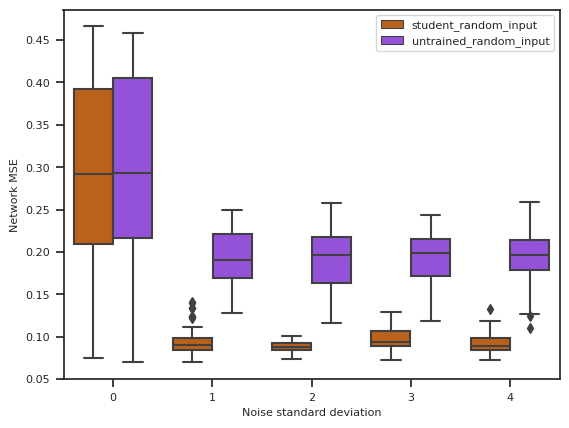

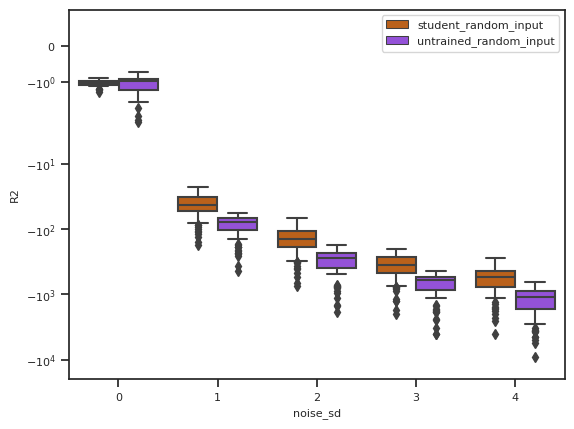

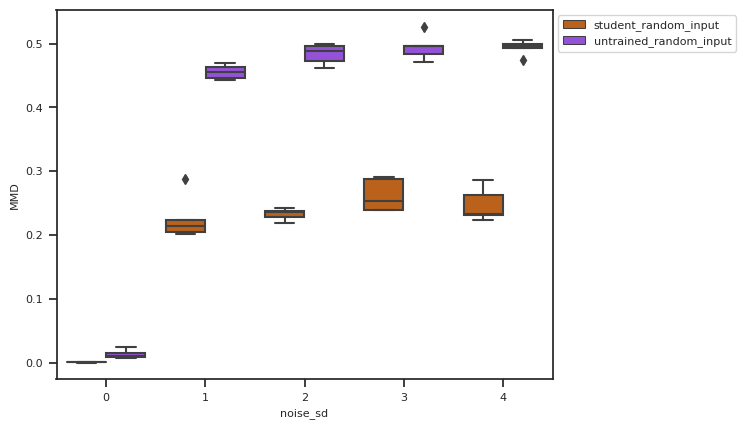

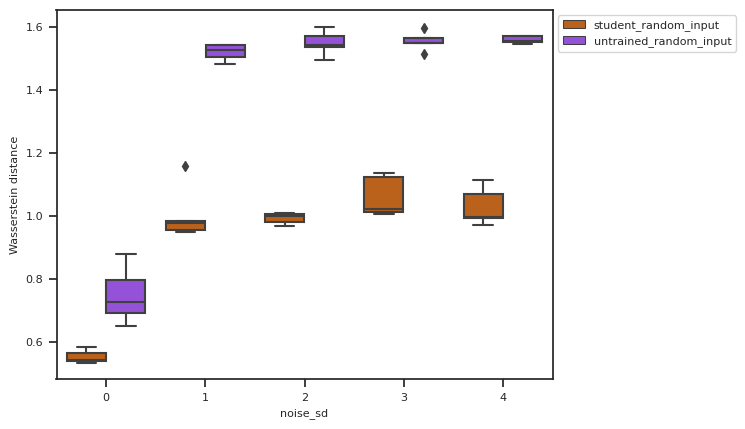

In [88]:
sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_random_input", "student_random_input"])], 
            x="noise_sd", y="MSE", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Noise standard deviation")
plt.ylabel("Network MSE")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MSE_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_random_input", "student_random_input"])], 
            x="noise_sd", y="R2", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim((-2e4, 1))
plt.yscale("symlog")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_R2_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()


sns.boxplot(data=mmd_emd[mmd_emd["model"].isin(["untrained_random_input", "student_random_input"])], 
            x="noise_sd", y="MMD", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MMD_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=mmd_emd[mmd_emd["model"].isin(["untrained_random_input", "student_random_input"])], 
            x="noise_sd", y="EMD", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("Wasserstein distance")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_EMD_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

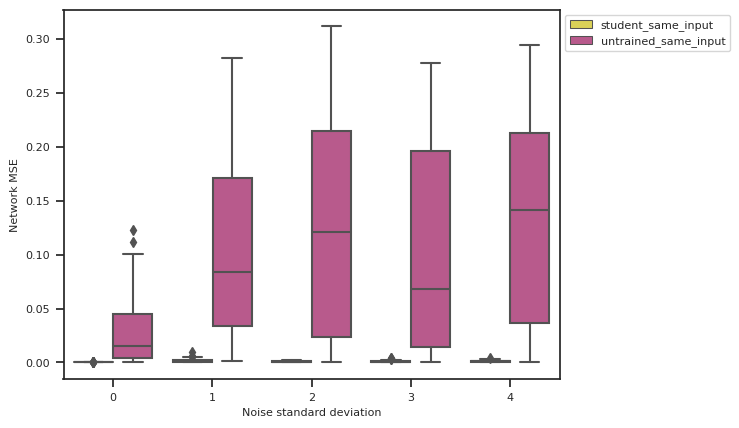

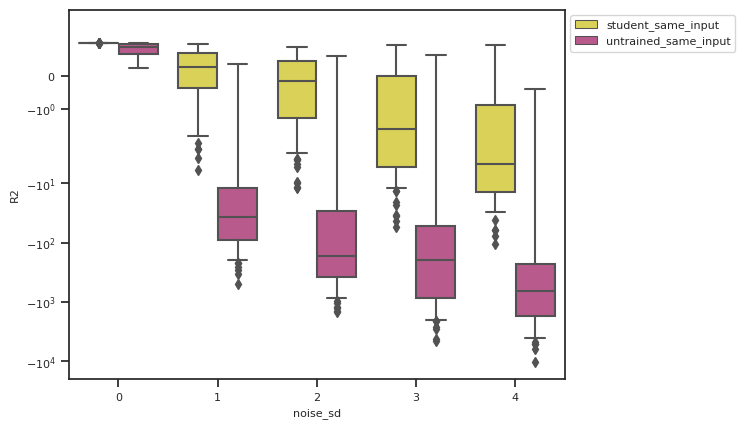

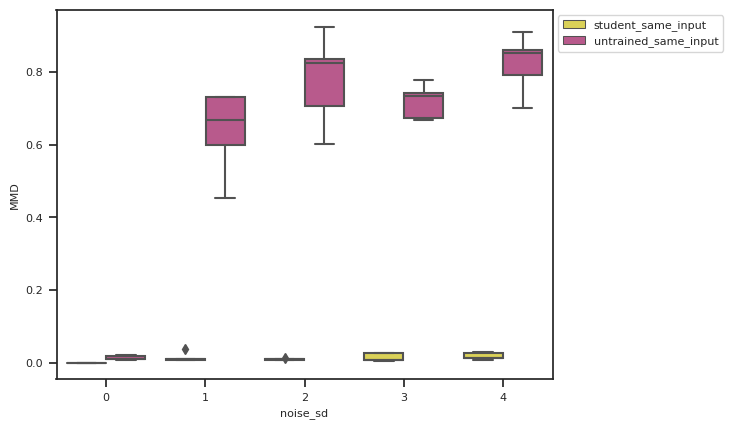

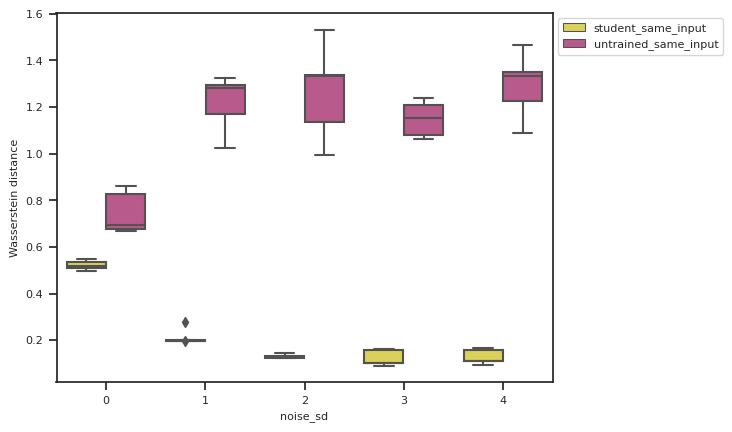

In [90]:
sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_same_input", "student_same_input"])], 
            x="noise_sd", y="MSE", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Noise standard deviation")
plt.ylabel("Network MSE")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MSE_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_same_input", "student_same_input"])], x="noise_sd", y="R2", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim((-2e4, 2))

plt.yscale("symlog")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_R2_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()


sns.boxplot(data=mmd_emd[mmd_emd["model"].isin(["untrained_same_input", "student_same_input"])], x="noise_sd", 
            y="MMD", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MMD_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=mmd_emd[mmd_emd["model"].isin(["untrained_same_input", "student_same_input"])], x="noise_sd", 
            y="EMD", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("Wasserstein distance")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_EMD_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()


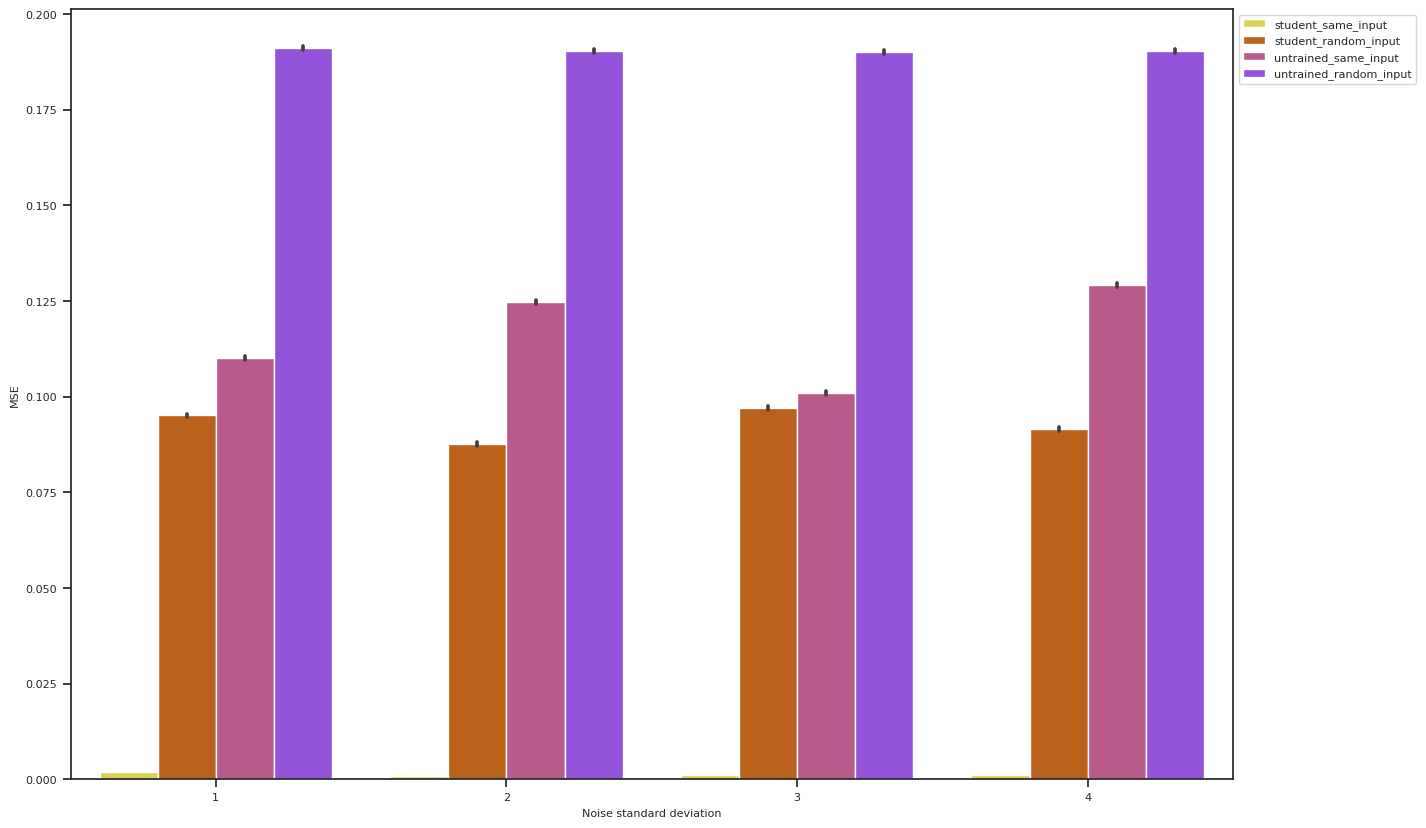

In [84]:
plt.figure(figsize=(15,10))
sns.barplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
plt.xlabel("Noise standard deviation")
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_bar.pdf", bbox_inches="tight")
plt.show()

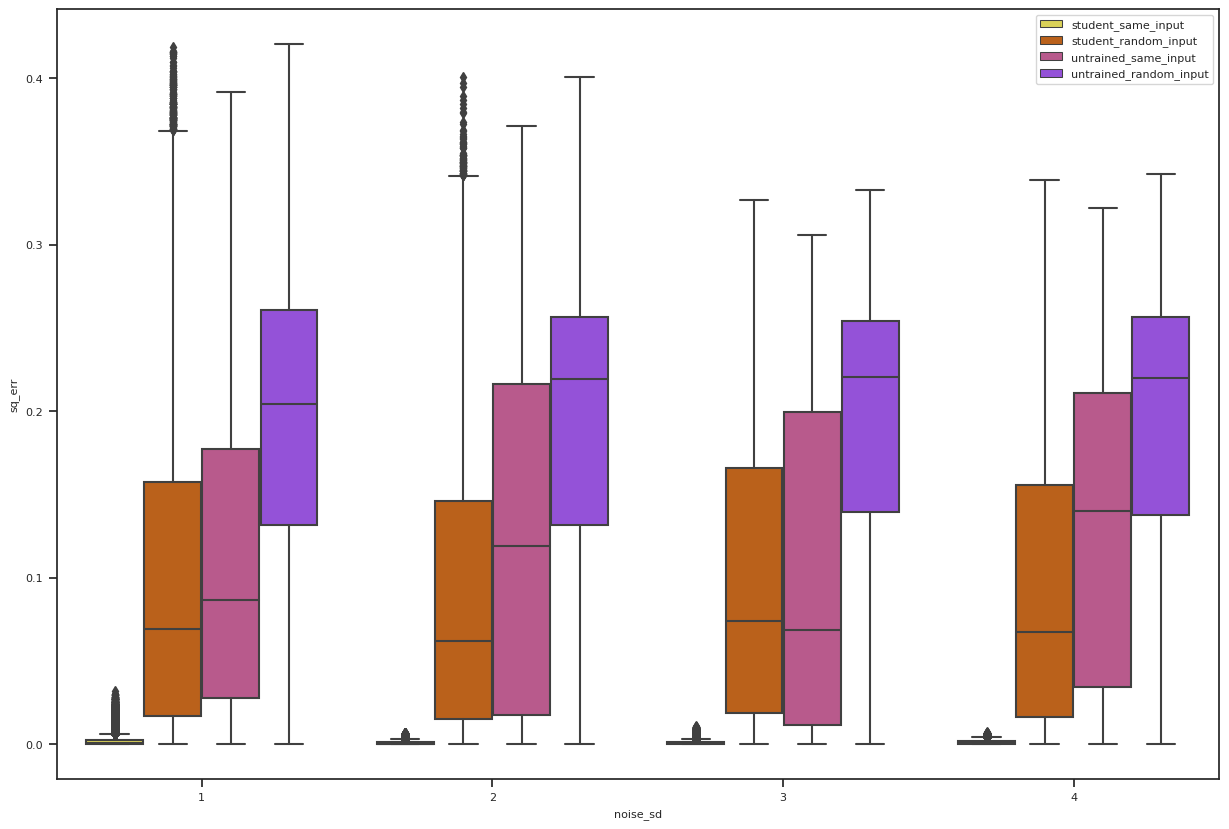

In [78]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_box.pdf", bbox_inches="tight")
plt.show()

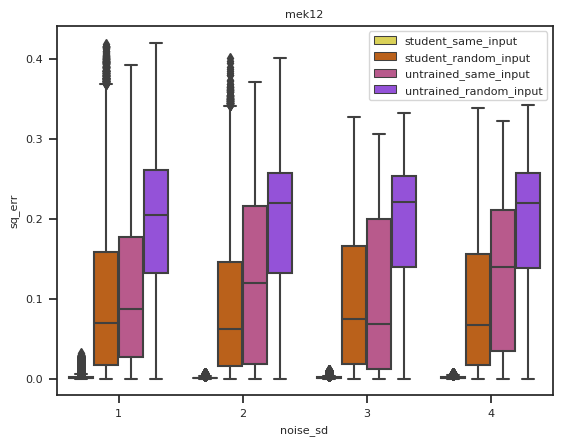

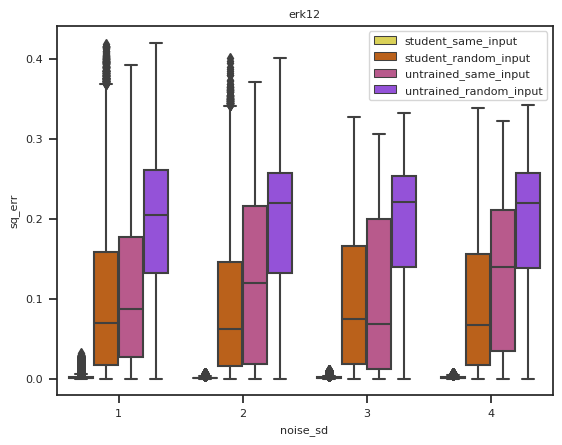

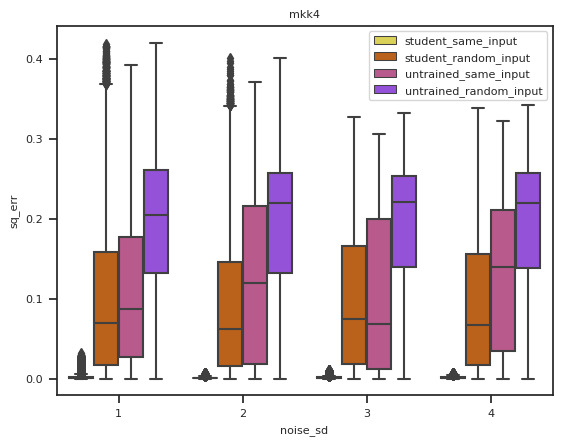

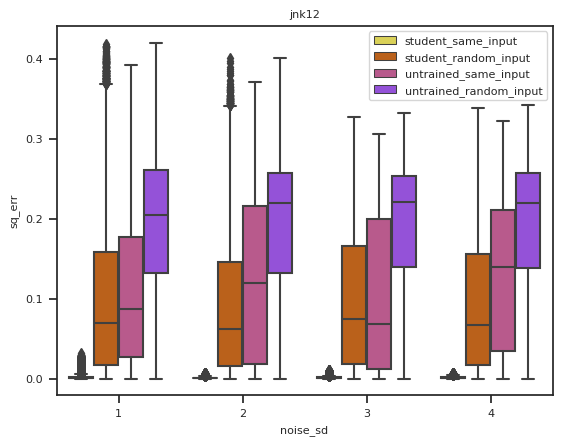

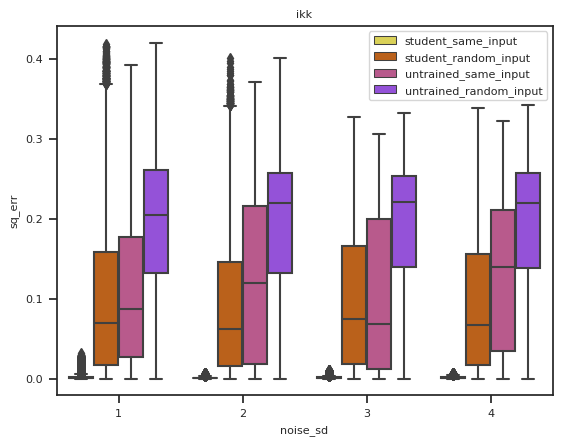

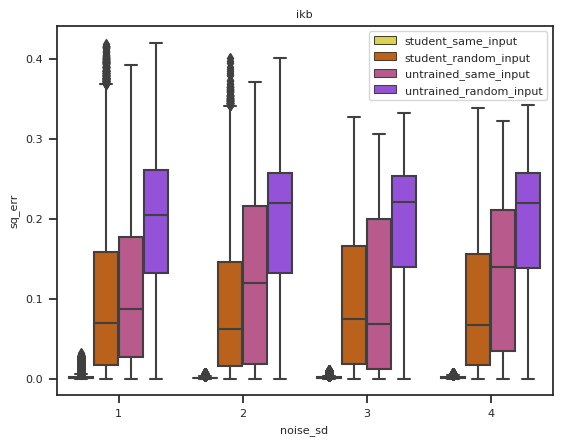

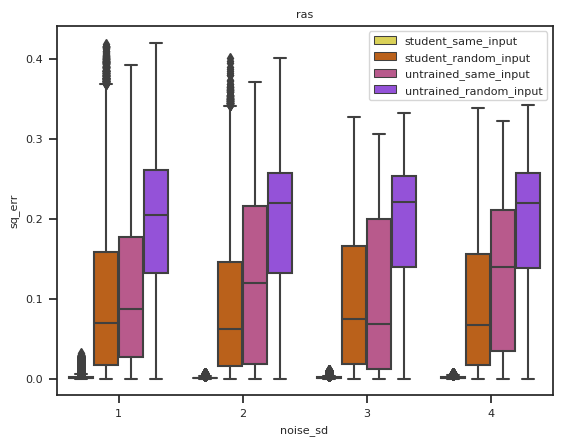

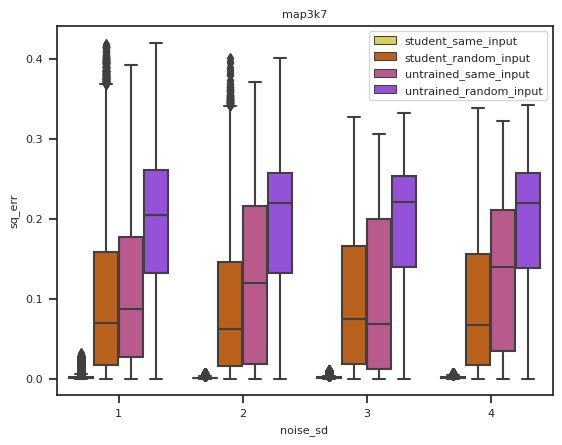

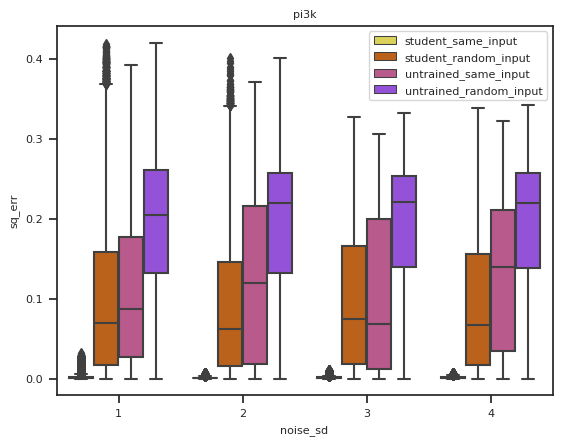

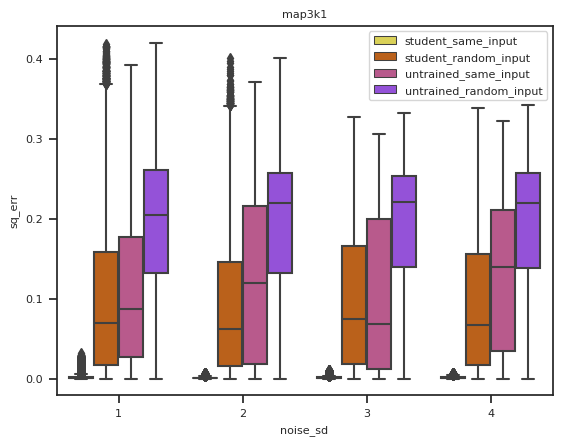

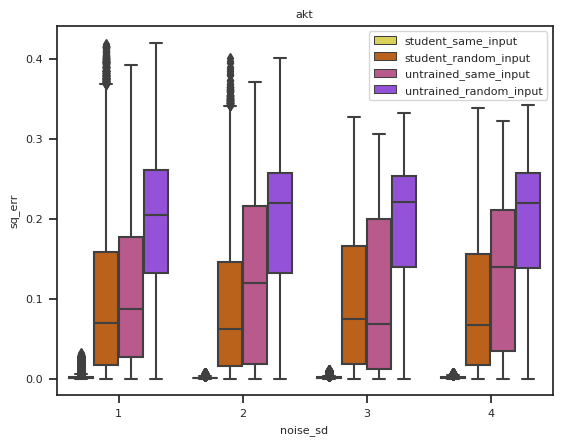

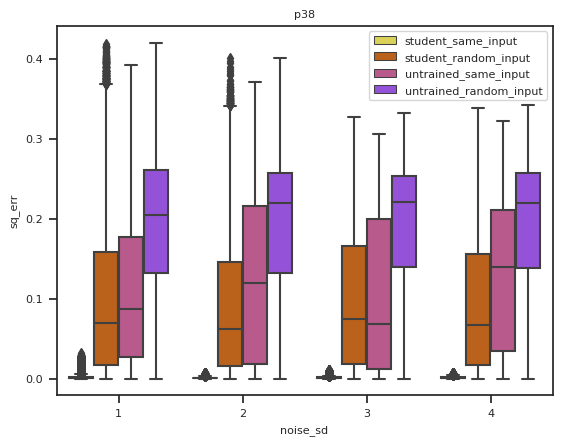

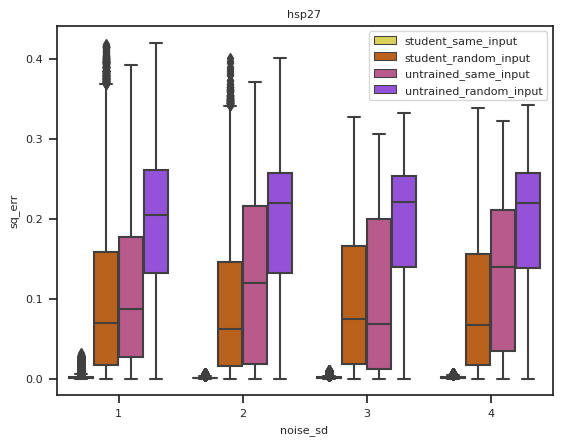

In [79]:
for n in df["marker"].unique():
    sel_df = df[df["marker"]==n]
    sns.boxplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(n)
    plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_{n}_box.pdf", bbox_inches="tight")
    plt.show()

In [80]:
df.max()

noise_sd                        4
repeat                          5
model        untrained_same_input
marker                        ras
pred                          1.0
true                     0.648344
error                    0.648295
sq_err                   0.420286
abs_error                0.648295
dtype: object

<AxesSubplot:xlabel='noise_sd', ylabel='sq_err'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


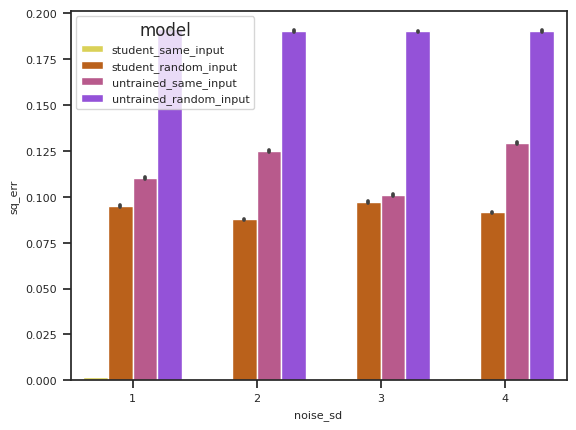

In [81]:
sns.barplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
